In [3]:
import medleydb as mdb
import librosa
import numpy as np
import matplotlib.pyplot as plt
import librosa.display
import pandas as pd
import IPython.display as ipd
import os
import random
from os import path
from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit
from sklearn.preprocessing import MultiLabelBinarizer

HOME_PATH = path.expanduser("~")

DATA_PATH = path.join(HOME_PATH, "data", "preprocessed")
if not os.path.exists(DATA_PATH):
    os.makedirs(DATA_PATH)

# Ändra till detta i en paketstruktur
# DATA_PATH = path.join(path.dirname(__file__), 'data', 'preprocessed')

# Based off of OpenMICs taxonomy discussions and the MedleyDB taxonomy yaml
OPENMIC_TO_MEDLEY = {
    "drums": ["drum set"],
    "bass": ["electric bass", "double bass"],
    "guitar": ["distorted electric guitar", "clean electric guitar", "acoustic guitar"],
    "voice": [
        "male singer",
        "female singer",
        "male speaker",
        "female speaker",
        "male rapper",
        "female rapper",
        "beatboxing",
        "vocalists",
        "choir",
        "male screamer",
        "female screamer",
    ],
    "piano": ["piano", "tack piano", "electric piano"],
}

INSTRUMENTS = OPENMIC_TO_MEDLEY.keys()
INSTRUMENT_INDEX = {key: i for i, (key, _) in enumerate(OPENMIC_TO_MEDLEY.items())}
MEDLEY_TO_OPENMIC = {v: k for k, v_list in OPENMIC_TO_MEDLEY.items() for v in v_list}
MEDLEY_TO_INDEX = {k: INSTRUMENT_INDEX[v] for k, v in MEDLEY_TO_OPENMIC.items()}
REV_INSTRUMENT_INDEX = {v: k for k, v in INSTRUMENT_INDEX.items()}

In [151]:
def create_train_val_test_split(tracks, test_size=0.2, val_size=0.2):
    X = []
    Y = []

    for t in tracks:
        X.append(t)
        instruments = {
            MEDLEY_TO_OPENMIC[i]
            for i in t.stem_instruments
            if i in MEDLEY_TO_OPENMIC.keys()
        }
        Y.append(list(instruments))

    mlb = MultiLabelBinarizer(list(INSTRUMENTS))
    Y = mlb.fit_transform(Y)
    X = np.array(X)

    test_train = MultilabelStratifiedShuffleSplit(
        n_splits=2, test_size=test_size, random_state=0
    )

    for train_index, test_index in test_train.split(X, Y):
        X_train, test = X[train_index], X[test_index]
        Y_train, Y_test = Y[train_index], Y[test_index]
        break

    train_val = MultilabelStratifiedShuffleSplit(
        n_splits=2, test_size=val_size, random_state=0
    )

    for train_index, test_index in train_val.split(X_train, Y_train):
        train, val = X_train[train_index], X_train[test_index]
        train_labels, val_labels = Y_train[train_index], Y_train[test_index]
        break

    print("Training sample length:", train.shape[0])
    print("Distribution:", np.sum(train_labels, axis=0))
    print("Validation sample length:", val.shape[0])
    print("Distribution:", np.sum(val_labels, axis=0))
    print("Test sample length", test.shape[0])
    print("Distribution:", np.sum(Y_test, axis=0))

    return train, val, test


tracks = mdb.load_all_multitracks(["V1", "V2"])
train, val, test = create_train_val_test_split(tracks, test_size=0.2, val_size=0.2)

# Example {"guitar": [stem_1.wav, ..., stem_n.wav], "bass": [stem_1.wav, ..., stem_n.wav]...}
def mdb_index(tracklist):
    files = {k: [] for k, v in OPENMIC_TO_MEDLEY.items()}
    for t in tracklist:
        for k, v in t.stems.items():
            # help(v)
            if v.instrument[0] in MEDLEY_TO_OPENMIC.keys():
                instrument = MEDLEY_TO_OPENMIC[v.instrument[0]]
                files[instrument].append(v.audio_path)
    return files



# Example {"ArtistSong" : {"guitar" : [stem_1.wav, stem_2.wav]} }
def mdb_baseline_index(tracklist):
    files = {}
    for t in tracklist:
        for k, v in t.stems.items():
            # help(v)
            if v.instrument[0] in MEDLEY_TO_OPENMIC.keys():
                instrument = MEDLEY_TO_OPENMIC[v.instrument[0]]
                if t.track_id not in files.keys():
                    files[t.track_id] = {k: [] for k, _ in OPENMIC_TO_MEDLEY.items()}
                files[t.track_id][instrument] = files[t.track_id].get(
                    instrument, []
                ) + [v.audio_path]
    return files


train_paths = mdb_index(train)
val_paths = mdb_baseline_index(val)
test_paths = mdb_baseline_index(test)

# samplerate = 16000
# window = 1024
# hop = 512
# duration = 8.191  # (8.192 - 0.001 because librosa round up)
# assert duration * samplerate / hop == 256
spectrogram_params = {
    "sample_rate": 16000,
    "spectrogram_len": 8.191,
    "n_fft": 1024,
    "hop_length": 512,
    "n_mels": 128,
    "duration": 8.191,
    "num_windows": 256,
}

/home/carlnys/data/medleydb/medleydb/multitrack.py:368: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  metadata = yaml.load(f_in)


Training sample length: 124
Distribution: [67 78 59 56 54]
Validation sample length: 31
Distribution: [17 19 15 14 14]
Test sample length 41
Distribution: [22 25 19 18 18]


In [184]:
def mix(files, spectrogram_params, baseline=False):
    num_windows = spectrogram_params['num_windows']
    duration = spectrogram_params['duration']
    spectrogram_len = spectrogram_params['spectrogram_len']
    n_fft = spectrogram_params['n_fft']
    hop_length = spectrogram_params['hop_length']
    n_mels = spectrogram_params['n_mels']
    sr = spectrogram_params['sample_rate']
    while True: 
        xs = []
        ys = []
        if baseline: 
            song_id, instrument_dict = random.choice(list(files.items()))
            d = None
            for instrument, stems in instrument_dict.items(): 
                # Same duration for all stems
                y = np.zeros((1, num_windows))
                for stem in stems:
                    if d is None:
                        d = librosa.get_duration(filename=stem)
                        offset = np.random.uniform(0.0, d - duration)
                    waveform, _ = librosa.load(stem, sr, res_type='kaiser_fast', offset=offset, duration=duration)
                    y = np.logical_or(y, (librosa.feature.rms(waveform) > 0.01))
                    x = librosa.feature.melspectrogram(waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                    x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
                    xs.append(x) 
                ys.append(y)
        else:
            for instrument, paths in files.items():
                path = random.choice(paths)
                d = librosa.get_duration(filename=path)
                offset = np.random.uniform(0.0, d - duration)
                waveform, _ = librosa.load(path, 16000, res_type='kaiser_fast', offset=offset, duration=duration)
                y = librosa.feature.rms(waveform) > 0.01
                x = librosa.feature.melspectrogram(waveform, sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
                x = librosa.power_to_db(x, ref=np.max).astype(np.float32)
                xs.append(x)
                ys.append(y)
        
        x = np.sum(np.array(xs), axis = 0)
        x = np.expand_dims(x, axis=0)
        y = np.stack(ys)
        y = y.reshape(y.shape[0], y.shape[2])
        y = y.astype(float)
        yield x, y
        
#files = index()
#train, test = split(files)
#train, validation = split(train)
## TODO batch, prefetch, cache(?), train, etc.
#for x, y in mix(train):
#    model.train(x, y)

from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import sigmoid
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import torch
import sys,os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import medleydb as mdb
import librosa
import librosa.display
import IPython.display as ipd
import sklearn.metrics as metrics
%matplotlib notebook

class MedleyDB(Dataset):
    def __init__(self, files, spectrogram_params, baseline = False, input_transform=None):
        self.files = files
        self.baseline = baseline
        self.spectrogram_params = spectrogram_params
    def __getitem__(self, idx):
        return next(mix(self.files, self.spectrogram_params, self.baseline))
    def __len__(self):    
        length = 0
        if self.baseline:
            for k, v in self.files.items():
                for instrument, stems in v.items():   
                    length += len(stems)
        else:
            for k, v in self.files.items():
                length += len(v)
        return length
     
        
batch_size = 32

train_data = MedleyDB(train_paths, spectrogram_params, False)
validation_data = MedleyDB(val_paths, spectrogram_params, True)
test_data = MedleyDB(test_paths, spectrogram_params, True) 

train = DataLoader(train_data, batch_size=batch_size, shuffle = True, num_workers=os.cpu_count())
validation = DataLoader(validation_data, batch_size=batch_size, shuffle = True, num_workers=os.cpu_count())
test = DataLoader(test_data, batch_size=batch_size, shuffle = True, num_workers=os.cpu_count())

False
(1, 128, 256)
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 

<IPython.core.display.Javascript object>


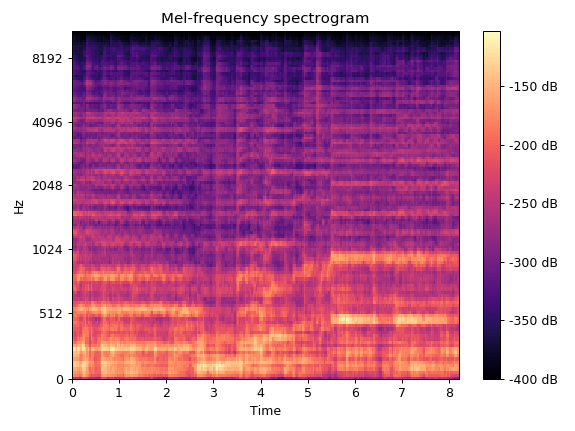

In [185]:
def display_spectrogram(s, p):
    librosa.display.specshow(s, x_axis='time',
                 y_axis='mel', sr=p['sample_rate'],
                 hop_length=p['hop_length'])
    plt.colorbar(format='%+2.0f dB')
    plt.title('Mel-frequency spectrogram')
    plt.tight_layout()
    plt.show()
    
x, y = next(iter(train_gen))
s = x.numpy()[0]
s1 = x.numpy()[1]

comparison = s1 == s
equal_arrays = comparison.all()

print(equal_arrays)


print(s.shape)
l = y.numpy()[0]
l2 = y.numpy()[1]
print(l2)
print(l.shape)
np.set_printoptions(threshold=sys.maxsize)
print(len(l[0]))
display_spectrogram(s[0], spectrogram_params)

In [188]:
# Trying to mimic TUT-SED Synthetic 2016 in 
# Convolutional Recurrent Neural Networks for
# Polyphonic Sound Event Detection
class CRNN(nn.Module):
    def __init__(self, gru_input, gru_hidden, gru_layers):
        super(CRNN, self).__init__()
        
        self.gru_input = gru_input
        self.gru_hidden = gru_hidden
        self.gru_layers = gru_layers
        
        # We only pool on the freq. axis
        self.pool_2x1 = nn.MaxPool2d([2,1])
        self.pool_4x1 = nn.MaxPool2d([4,1])
        
        self.conv1 = nn.Conv2d(in_channels = 1,
                                 out_channels = 32,
                                 kernel_size = 3,
                                 stride = 1,
                                 padding = 1)
        self.conv1_bn = nn.BatchNorm2d(32)
        
        self.conv2 = nn.Conv2d(in_channels = 32,
                                 out_channels = 64,
                                 kernel_size = 3,
                                 stride = 1,
                                 padding = 1)
        self.conv2_bn = nn.BatchNorm2d(64)
        
        self.conv3 = nn.Conv2d(in_channels = 64,
                                 out_channels = 128,
                                 kernel_size = 3,
                                 stride = 1,
                                 padding = 1)
        self.conv3_bn = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(in_channels = 128,
                                 out_channels = 256,
                                 kernel_size = 3,
                                 stride = 1,
                                 padding = 1)
        self.conv4_bn = nn.BatchNorm2d(256)
        
        # now stack -> [batch_size, 256, 1, 256] -> [batch_size, 256*1, 256]
        
        # (input shape (w.o batch), hidden shape, n_layers, batch_first=True)
        self.gru = nn.GRU(gru_input, gru_hidden, gru_layers, batch_first=True)
        # torch.Size([batch_size, 256, 1, 256])
        self.fc = nn.Linear(256, 5)
         

    def forward(self, x, h):
        #print(x.shape)
        # add sequence of convolutional and max pooling layers
        x = F.relu(self.pool_4x1(self.conv1_bn(self.conv1(x))))
        #print(x.shape)
        x = F.relu(self.pool_4x1(self.conv2_bn(self.conv2(x))))
        #print(x.shape)
        x = F.relu(self.pool_4x1(self.conv3_bn(self.conv3(x))))
        #print(x.shape)
        x = F.relu(self.pool_2x1(self.conv4_bn(self.conv4(x))))
       # print("After CNN", x.shape)
        # torch.Size([batch_size, 256, 1, 256])
        # (batch x classes x 1 x time) -> (batch x classes x time)
        x = x.view(x.shape[0], 256, 256)
        # Gru expects (batch, seq, feature)
        # The sequence in this case is our time axis
        x = x.permute(0, 2, 1)
       # print("After permute", x.shape) 
        x, h = self.gru(x, h)
       # print("After gru", x.shape)
        x = self.fc(x)
       # print("After fc,", x.shape)
        # (batch_size, seq, num_classes)
        x = x.permute(0, 2, 1)
       # print("After permute back", x.shape)   
        return x, h

    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        # Create two new tensors with sizes n_layers x batch_size x n_hidden,
        # initialized to zero, for hidden state and cell state of LSTM
        #(n_layers, batch, n_hidden)
        h0 = Variable(torch.zeros(self.gru_layers, batch_size, self.gru_hidden)).cuda()
        return h0

In [189]:
gpu_available = torch.cuda.is_available()
lr = 0.001
batch_size = batch_size
model = CRNN(gru_input = 256, gru_hidden = 256, gru_layers = 1)
params = model.parameters()
# Binary Cross-Entropy Loss
if gpu_available:
    model.cuda()
    criterion = nn.BCEWithLogitsLoss().cuda()
    #optimizer = optim.SGD(model.parameters(), lr=lr)    
    optimizer = optim.Adam(model.parameters(), lr=1e-4)    
n_epochs = 15
len_data = len(train.dataset)
print(len_data)
num_batches = len_data//batch_size

427


In [190]:
def train_model(model_name, crnn=False):
    validation_loss_min = sys.maxsize
    train_losses = []
    validation_losses = []
    for epoch in range(1, n_epochs+1):
        if crnn: 
            h = model.init_hidden(batch_size)
            val_h = model.init_hidden(batch_size)
        print("Epoch: {}/{}".format(epoch, n_epochs))
        # keep track of training and validation loss
        train_loss = 0.0
        validation_loss = 0.0
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(train):
            print("Batch: {}/{}".format(batch_idx, num_batches), end="\r")
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.float().cuda(), target.float().cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            if crnn:
                # Creating new variables for the hidden state, otherwise
                # we'd backprop through the entire training history
                h = model.init_hidden(data.shape[0])
                output, h = model(data, h)
            # forward pass: compute predicted outputs by passing inputs to the model
            #print(data.shape)
            else:
                output = model(data)
            #print(output.shape)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update training loss, loss.item is the avarage loss of the batch.
            train_loss += loss.item()*data.size(0)
            ######################    
            # validate the model #
            ######################
        model.eval()
        for data, target in validation:
            # move tensors to GPU if CUDA is available
            if gpu_available:
                data, target = data.cuda(), target.cuda()
            # forward pass: compute predicted outputs by passing inputs to the model
            if crnn: 
                # Detatching hidden state from the computational graph 
                # (see truncated back propagation through time) such that
                # the graph doesn't become super big, slowing down computations
                # and exploding the gradient. 

                # Note however that the hidden state VALUE will still be inherited
                # We just say that it doesn't depend on previous hidden states
                val_h = model.init_hidden(data.shape[0])
                output, val_h = model(data, val_h)
            else:
                output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update average validation loss 
            validation_loss += loss.item()*data.size(0)
                
         # calculate average losses
        train_loss = train_loss/len(train.sampler)
        validation_loss = validation_loss/len(validation.sampler)
        train_losses.append(train_loss)
        validation_losses.append(validation_loss)
       # plot_loss(train_losses, validation_losses)
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
            epoch, train_loss, validation_loss))

        # save model if validation loss has decreased
        if validation_loss <= validation_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            validation_loss_min,
            validation_loss))
            if crnn:
                torch.save(model.state_dict(), 'crnn_%s.pt' % model_name)
            else:
                torch.save(model.state_dict(), '%s.pt' % model_name)
            validation_loss_min = validation_loss
    
    if crnn:
        torch.save(model.state_dict(), 'overfit_crnn_%s.pt' % model_name)
    else:
        torch.save(model.state_dict(), 'overfit_.pt' % model_name)

In [ ]:
train_model(model_name="mixing_model", crnn=True)

Epoch: 1/15
Epoch: 1 	Training Loss: 0.636659 	Validation Loss: 0.670714
Validation loss decreased (9223372036854775808.000000 --> 0.670714).  Saving model ...
Epoch: 2/15
Epoch: 2 	Training Loss: 0.582178 	Validation Loss: 0.686233
Epoch: 3/15
Epoch: 3 	Training Loss: 0.573312 	Validation Loss: 0.723312
Epoch: 4/15
Epoch: 4 	Training Loss: 0.565474 	Validation Loss: 0.660517
Validation loss decreased (0.670714 --> 0.660517).  Saving model ...
Epoch: 5/15
Epoch: 5 	Training Loss: 0.559670 	Validation Loss: 0.619149
Validation loss decreased (0.660517 --> 0.619149).  Saving model ...
Epoch: 6/15
